In [39]:
!pip install kaggle

In [40]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Move the kaggle.json file to the correct directory
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [41]:
!kaggle datasets download -d phylake1337/fire-dataset

fire-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [42]:
!unzip -q fire-dataset.zip

replace fire_dataset/fire_images/fire.1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [44]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-02-02 01:13:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-02 01:13:26 (70.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [82]:
# Set your data path
data_path = '/content/fire_dataset'

In [83]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [84]:
# Create a list of all image files and labels
all_images = []
labels = []

for label in ['fire_images', 'non_fire_images']:
    label_path = os.path.join(data_path, label)
    image_files = [os.path.join(label, img) for img in os.listdir(label_path)]
    all_images.extend(image_files)
    labels.extend([label] * len(image_files))

In [85]:
# Split the data into training, validation, and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(all_images, labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [86]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [87]:
# No data augmentation for validation/test images
test_datagen = ImageDataGenerator(rescale=1./255)

In [88]:
# Load training data
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_images, 'label': train_labels}),
    directory=data_path,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 639 validated image filenames belonging to 2 classes.


In [89]:
# Load validation data
val_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': val_images, 'label': val_labels}),
    directory=data_path,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 160 validated image filenames belonging to 2 classes.


In [90]:
# Load test data
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': test_images, 'label': test_labels}),
    directory=data_path,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 200 validated image filenames belonging to 2 classes.


In [91]:
# Load pre-trained VGG-19 model without top layer (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [92]:
# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [93]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE
)

Epoch 1/20
19/19 [==============================] - 24s 1s/step - loss: 1.9773 - accuracy: 0.6870 - val_loss: 0.3204 - val_accuracy: 0.8500
Epoch 2/20
19/19 [==============================] - 23s 1s/step - loss: 0.3659 - accuracy: 0.8487 - val_loss: 0.2900 - val_accuracy: 0.8750
Epoch 3/20
19/19 [==============================] - 21s 1s/step - loss: 0.2987 - accuracy: 0.8600 - val_loss: 0.2832 - val_accuracy: 0.8625
Epoch 4/20
19/19 [==============================] - 22s 1s/step - loss: 0.2640 - accuracy: 0.8682 - val_loss: 0.2342 - val_accuracy: 0.9062
Epoch 5/20
19/19 [==============================] - 22s 1s/step - loss: 0.2172 - accuracy: 0.9094 - val_loss: 0.2015 - val_accuracy: 0.9062
Epoch 6/20
19/19 [==============================] - 23s 1s/step - loss: 0.2165 - accuracy: 0.8962 - val_loss: 0.2350 - val_accuracy: 0.9187
Epoch 7/20
19/19 [==============================] - 23s 1s/step - loss: 0.2045 - accuracy: 0.9176 - val_loss: 0.1888 - val_accuracy: 0.9312
Epoch 8/20
19/19 [==

In [95]:
results = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

6/6 [==============================] - 3s 446ms/step - loss: 0.2604 - accuracy: 0.9115
    Test Loss: 0.26041
Test Accuracy: 91.15%


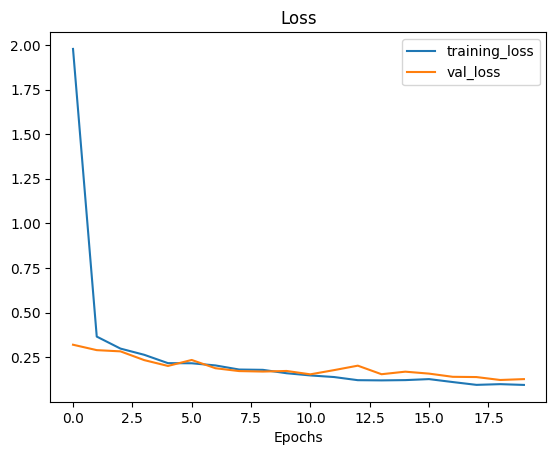

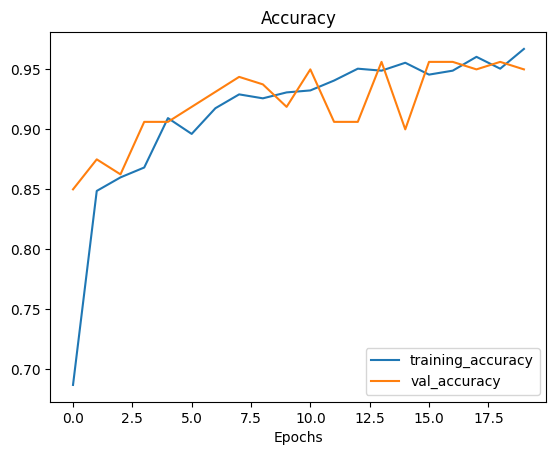

In [96]:
plot_loss_curves(history)

In [97]:
# Predict on the validation set
val_predictions = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE)
val_predicted_labels = (val_predictions > 0.5).astype(int).flatten()
val_true_labels = val_generator.classes

5/5 [==============================] - 2s 499ms/step


In [98]:
print(f'Training Loss: {history.history["loss"][-1]:.4f}')
print(f'Training Accuracy: {history.history["accuracy"][-1] * 100:.2f}%')
print(f'Last Validation Loss: {history.history["val_loss"][-1]:.4f}')
print(f'Last Validation Accuracy: {history.history["val_accuracy"][-1] * 100:.2f}%')

Training Loss: 0.0952
Training Accuracy: 96.71%
Last Validation Loss: 0.1277
Last Validation Accuracy: 95.00%


In [99]:
# Generate classification report for validation set
from sklearn.metrics import classification_report
print("Validation Set Classification Report:")
print(classification_report(val_true_labels, val_predicted_labels))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       116
           1       0.36      0.34      0.35        44

    accuracy                           0.65       160
   macro avg       0.56      0.55      0.55       160
weighted avg       0.65      0.65      0.65       160

